<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [ ]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [ ]:
from google.colab import drive
import zipfile
import os
drive.mount('/content/drive')
#!tar -xvf '/content/drive/MyDrive/Colab Notebooks/Deep Learning for Industrial Application /HW3/cable.tar.gz' cable


# Unzip the cable dataset again after reset
cable_zip_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning for Industrial Application /HW3/cable.zip"
cable_extract_path = "/content/cable"

with zipfile.ZipFile(cable_zip_path, 'r') as zip_ref:
    zip_ref.extractall(cable_extract_path)

# List contents to confirm structure
print(os.listdir(cable_extract_path))

Mounted at /content/drive
['ground_truth', 'test', 'license.txt', 'readme.txt', 'train']


In [ ]:
# Update glob path to match extraction location
file_paths = glob.glob('cable/*/*/*.png')
file_paths = sorted(file_paths)


# Load and preprocess train/good images
train_good_paths = glob.glob('/content/cable/train/good/*.png')

def load_images(paths, size=(64, 64)):
    imgs = []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        img = img.astype(np.float32) / 255.0
        imgs.append(img)
    return np.array(imgs)
train_imgs = load_images(train_good_paths)
print(f"Loaded {len(train_imgs)} train/good images")

test_paths = glob.glob('/content/cable/test/*/*.png')
test_imgs = load_images(test_paths)  # 使用之前定義的 load_images function
print(f"Loaded {len(test_imgs)} test images")


Loaded 224 train/good images
Loaded 150 test images


## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Convert to torch tensor
x_train_tensor = torch.tensor(train_imgs.transpose(0, 3, 1, 2))  # NHWC -> NCHW
train_dataset = TensorDataset(x_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

x_test_tensor = torch.tensor(test_imgs.transpose(0, 3, 1, 2))
test_dataset = TensorDataset(x_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## B. Defining Neural Networks

In [ ]:
# Q2 - Attempt 1
# Define a simple convolutional autoencoder
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),# 16x16
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model_attempt1 = ConvAutoencoder().to("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Q2 - Attempt 2: Autoencoder with Data Augmentation
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
class AugmentedImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = (img * 255).astype(np.uint8)  # to [0,255] for PIL
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img

# Define augmentation
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

model_attempt2 = ConvAutoencoder().to("cuda" if torch.cuda.is_available() else "cpu")
aug_dataset = AugmentedImageDataset(train_imgs, transform=aug_transform)
aug_loader = DataLoader(aug_dataset, batch_size=32, shuffle=True)

In [ ]:
# Q2 - Attempt 3: ResNet18 encoder with custom decoder

import torchvision.models as models

class ResNetAE(nn.Module):
    def __init__(self):
        super(ResNetAE, self).__init__()
        # Load pre-trained resnet18 and remove classifier
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # keep up to layer4 (output: 512x4x4 for 128x128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1), # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),    # 128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
model_attempt3 = ResNetAE().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Q2 - Attempt 4: reset model

model_attempt4 = ResNetAE().to(device)

## C. Training the Neural Network

In [ ]:
# Q2-attempt1 Train the autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_attempt1.parameters(), lr=1e-3)

num_epochs = 50
train_losses = []
test_losses = []
model_attempt1.train()

for epoch in range(num_epochs):
    epoch_train_loss = 0
    for batch in train_loader:
        imgs = batch[0].to(device)
        outputs = model_attempt1(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Evaluate test loss
    model_attempt1.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            imgs = batch[0].to(device)
            outputs = model_attempt1(imgs)
            loss = criterion(outputs, imgs)
            epoch_test_loss += loss.item()
    model_attempt1.train()

    train_avg = epoch_train_loss / len(train_loader)
    test_avg = epoch_test_loss / len(test_loader)
    train_losses.append(train_avg)
    test_losses.append(test_avg)

    print(f"Epoch {epoch+1} | Train Loss: {train_avg:.4f} | Test Loss: {test_avg:.4f}")

Epoch 1 | Train Loss: 0.0546 | Test Loss: 0.0514
Epoch 2 | Train Loss: 0.0509 | Test Loss: 0.0483
Epoch 3 | Train Loss: 0.0472 | Test Loss: 0.0442
Epoch 4 | Train Loss: 0.0418 | Test Loss: 0.0365
Epoch 5 | Train Loss: 0.0334 | Test Loss: 0.0303
Epoch 6 | Train Loss: 0.0291 | Test Loss: 0.0271
Epoch 7 | Train Loss: 0.0259 | Test Loss: 0.0237
Epoch 8 | Train Loss: 0.0227 | Test Loss: 0.0206
Epoch 9 | Train Loss: 0.0200 | Test Loss: 0.0187
Epoch 10 | Train Loss: 0.0182 | Test Loss: 0.0165
Epoch 11 | Train Loss: 0.0167 | Test Loss: 0.0154
Epoch 12 | Train Loss: 0.0155 | Test Loss: 0.0145
Epoch 13 | Train Loss: 0.0148 | Test Loss: 0.0137
Epoch 14 | Train Loss: 0.0140 | Test Loss: 0.0130
Epoch 15 | Train Loss: 0.0133 | Test Loss: 0.0124
Epoch 16 | Train Loss: 0.0128 | Test Loss: 0.0120
Epoch 17 | Train Loss: 0.0123 | Test Loss: 0.0116
Epoch 18 | Train Loss: 0.0120 | Test Loss: 0.0123
Epoch 19 | Train Loss: 0.0128 | Test Loss: 0.0122
Epoch 20 | Train Loss: 0.0120 | Test Loss: 0.0109
Epoch 21 

In [ ]:
# Q2-attempt2 Train autoencoder with augmented data
train_losses_aug = []
test_losses_aug = []

optimizer = torch.optim.Adam(model_attempt2.parameters(), lr=1e-3)

model_attempt2.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    for imgs in aug_loader:
        imgs = imgs.to(device)
        outputs = model_attempt2(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Evaluate on test set
    model_attempt2.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            imgs = batch[0].to(device)
            outputs = model_attempt2(imgs)
            loss = criterion(outputs, imgs)
            epoch_test_loss += loss.item()
    model_attempt2.train()

    train_avg = epoch_train_loss / len(aug_loader)
    test_avg = epoch_test_loss / len(test_loader)
    train_losses_aug.append(train_avg)
    test_losses_aug.append(test_avg)

    print(f"[Aug] Epoch {epoch+1} | Train Loss: {train_avg:.4f} | Test Loss: {test_avg:.4f}")

[Aug] Epoch 1 | Train Loss: 0.0690 | Test Loss: 0.0534
[Aug] Epoch 2 | Train Loss: 0.0624 | Test Loss: 0.0476
[Aug] Epoch 3 | Train Loss: 0.0564 | Test Loss: 0.0440
[Aug] Epoch 4 | Train Loss: 0.0504 | Test Loss: 0.0393
[Aug] Epoch 5 | Train Loss: 0.0420 | Test Loss: 0.0352
[Aug] Epoch 6 | Train Loss: 0.0373 | Test Loss: 0.0332
[Aug] Epoch 7 | Train Loss: 0.0343 | Test Loss: 0.0296
[Aug] Epoch 8 | Train Loss: 0.0303 | Test Loss: 0.0254
[Aug] Epoch 9 | Train Loss: 0.0266 | Test Loss: 0.0226
[Aug] Epoch 10 | Train Loss: 0.0237 | Test Loss: 0.0201
[Aug] Epoch 11 | Train Loss: 0.0215 | Test Loss: 0.0183
[Aug] Epoch 12 | Train Loss: 0.0197 | Test Loss: 0.0169
[Aug] Epoch 13 | Train Loss: 0.0185 | Test Loss: 0.0159
[Aug] Epoch 14 | Train Loss: 0.0176 | Test Loss: 0.0159
[Aug] Epoch 15 | Train Loss: 0.0170 | Test Loss: 0.0142
[Aug] Epoch 16 | Train Loss: 0.0162 | Test Loss: 0.0138
[Aug] Epoch 17 | Train Loss: 0.0154 | Test Loss: 0.0135
[Aug] Epoch 18 | Train Loss: 0.0151 | Test Loss: 0.0129
[

In [ ]:
# Q2-Attempt3 Train ResNet-based autoencoder
train_losses_resnet = []
test_losses_resnet = []

optimizer = torch.optim.Adam(model_attempt3.parameters(), lr=1e-3)

model_attempt3.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    for batch in train_loader:
        imgs = batch[0].to(device)
        outputs = model_attempt3(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Evaluate test loss
    model_attempt3.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            imgs = batch[0].to(device)
            outputs = model_attempt3(imgs)
            loss = criterion(outputs, imgs)
            epoch_test_loss += loss.item()
    model_attempt3.train()

    train_avg = epoch_train_loss / len(train_loader)
    test_avg = epoch_test_loss / len(test_loader)
    train_losses_resnet.append(train_avg)
    test_losses_resnet.append(test_avg)

    print(f"[ResNet18] Epoch {epoch+1} | Train Loss: {train_avg:.4f} | Test Loss: {test_avg:.4f}")

[ResNet18] Epoch 1 | Train Loss: 0.0568 | Test Loss: 0.0483
[ResNet18] Epoch 2 | Train Loss: 0.0416 | Test Loss: 0.0356
[ResNet18] Epoch 3 | Train Loss: 0.0326 | Test Loss: 0.0302
[ResNet18] Epoch 4 | Train Loss: 0.0276 | Test Loss: 0.0253
[ResNet18] Epoch 5 | Train Loss: 0.0232 | Test Loss: 0.0213
[ResNet18] Epoch 6 | Train Loss: 0.0201 | Test Loss: 0.0189
[ResNet18] Epoch 7 | Train Loss: 0.0184 | Test Loss: 0.0178
[ResNet18] Epoch 8 | Train Loss: 0.0173 | Test Loss: 0.0168
[ResNet18] Epoch 9 | Train Loss: 0.0166 | Test Loss: 0.0166
[ResNet18] Epoch 10 | Train Loss: 0.0162 | Test Loss: 0.0160
[ResNet18] Epoch 11 | Train Loss: 0.0157 | Test Loss: 0.0158
[ResNet18] Epoch 12 | Train Loss: 0.0152 | Test Loss: 0.0156
[ResNet18] Epoch 13 | Train Loss: 0.0149 | Test Loss: 0.0155
[ResNet18] Epoch 14 | Train Loss: 0.0147 | Test Loss: 0.0153
[ResNet18] Epoch 15 | Train Loss: 0.0144 | Test Loss: 0.0151
[ResNet18] Epoch 16 | Train Loss: 0.0141 | Test Loss: 0.0151
[ResNet18] Epoch 17 | Train Loss:

In [ ]:
# Q2-Attempt4 base on attempt3, change the learning rate
train_losses_resnet_attempt4 = []
test_losses_resnet_attempt4 = []

optimizer = torch.optim.Adam(model_attempt4.parameters(), lr=5*1e-4)

model_attempt4.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    for batch in train_loader:
        imgs = batch[0].to(device)
        outputs = model_attempt4(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Evaluate test loss
    model_attempt4.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            imgs = batch[0].to(device)
            outputs = model_attempt4(imgs)
            loss = criterion(outputs, imgs)
            epoch_test_loss += loss.item()
    model_attempt4.train()

    train_avg = epoch_train_loss / len(train_loader)
    test_avg = epoch_test_loss / len(test_loader)
    train_losses_resnet_attempt4.append(train_avg)
    test_losses_resnet_attempt4.append(test_avg)

    print(f"[ResNet18] Epoch {epoch+1} | Train Loss: {train_avg:.4f} | Test Loss: {test_avg:.4f}")

[ResNet18] Epoch 1 | Train Loss: 0.0519 | Test Loss: 0.0481
[ResNet18] Epoch 2 | Train Loss: 0.0442 | Test Loss: 0.0394
[ResNet18] Epoch 3 | Train Loss: 0.0358 | Test Loss: 0.0330
[ResNet18] Epoch 4 | Train Loss: 0.0308 | Test Loss: 0.0291
[ResNet18] Epoch 5 | Train Loss: 0.0273 | Test Loss: 0.0261
[ResNet18] Epoch 6 | Train Loss: 0.0243 | Test Loss: 0.0230
[ResNet18] Epoch 7 | Train Loss: 0.0218 | Test Loss: 0.0205
[ResNet18] Epoch 8 | Train Loss: 0.0197 | Test Loss: 0.0190
[ResNet18] Epoch 9 | Train Loss: 0.0183 | Test Loss: 0.0181
[ResNet18] Epoch 10 | Train Loss: 0.0173 | Test Loss: 0.0170
[ResNet18] Epoch 11 | Train Loss: 0.0166 | Test Loss: 0.0167
[ResNet18] Epoch 12 | Train Loss: 0.0161 | Test Loss: 0.0162
[ResNet18] Epoch 13 | Train Loss: 0.0156 | Test Loss: 0.0159
[ResNet18] Epoch 14 | Train Loss: 0.0153 | Test Loss: 0.0160
[ResNet18] Epoch 15 | Train Loss: 0.0149 | Test Loss: 0.0156
[ResNet18] Epoch 16 | Train Loss: 0.0147 | Test Loss: 0.0154
[ResNet18] Epoch 17 | Train Loss:

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

### Visualizing model performance

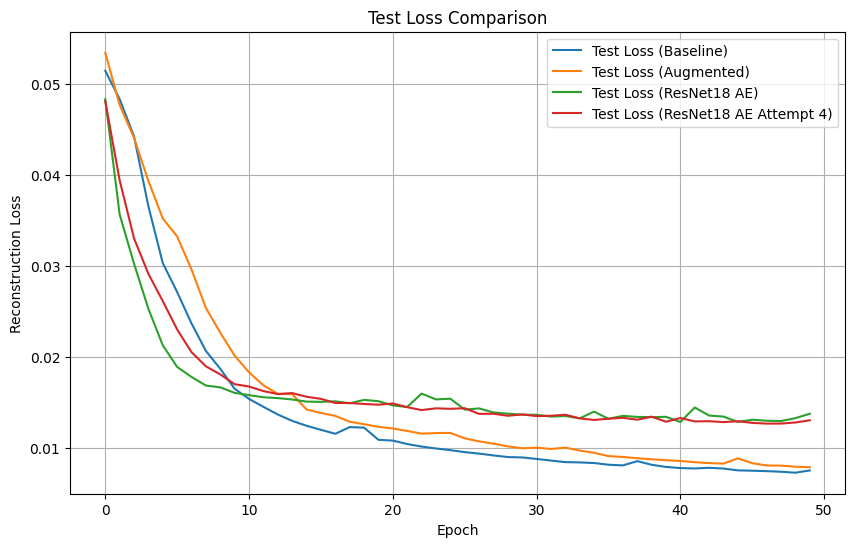

In [ ]:
# ✅ Compare baseline, aug, mild aug, and pretrained ResNet AE
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss (Baseline)')
plt.plot(test_losses_aug, label='Test Loss (Augmented)')
plt.plot(test_losses_resnet, label='Test Loss (ResNet18 AE)')
plt.plot(test_losses_resnet_attempt4, label='Test Loss (ResNet18 AE Attempt 4)')

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Test Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()